In [1]:
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal

from approx_topk.torch_default import bucket_topk

In [2]:
# Not correct when there's repeated values, but should be OK here
def calculate_recall(out1: Tensor, out2: Tensor) -> Tensor:
    # out1 -- (*, k), out2 -- (*, k)
    assert out1.size(-1) == out2.size(-1)

    out1_ = out1.unsqueeze(-1)  # (*, k, 1)
    out2_ = out2.unsqueeze(-2)  # (*, 1, k)
    return (out1_ == out2_).any(dim=-1).mean(dim=-1, dtype=torch.float)

In [3]:
def get_cov_matrix(n_points: int, corr_factor: float) -> Tensor:
    i1 = torch.arange(n_points)[None, :]
    i2 = torch.arange(n_points)[:, None]
    return corr_factor ** abs(i1 - i2)


def generate_data(n_repetitions: int, n_points: int, corr_factor: float) -> Tensor:
    mu = torch.zeros(n_points, dtype=torch.float)
    cov = get_cov_matrix(n_points, corr_factor)
    dist = MultivariateNormal(mu, cov)
    return dist.sample((n_repetitions,))

In [4]:
def experiment(data: Tensor, k: int, k_per_bucket: int, interleaved: bool, k_mult: int):
    topk_out = bucket_topk(
        data,
        k=k,
        dim=-1,
        k_mult=k_mult,
        k_per_bucket=k_per_bucket,
        interleaved=interleaved,
    )
    topk_out_exact = torch.topk(data, k=k, dim=-1)
    recall = calculate_recall(topk_out[0], topk_out_exact[0])
    return recall.mean(dim=0).item(), recall.std(dim=0).item()

In [5]:
# Check how varying n affects the recall curves

n_repetitions = 100
corr_factor = 0.5
k_factor = 8
k_mult = 1

results = []

for n in [2**e for e in range(9, 14)]:
    data = generate_data(n_repetitions, n, corr_factor)
    for interleaved in [False, True]:
        for k_per_bucket in [1, 2, 4, 8]:
            k = n // k_factor
            recall_mean, recall_std = experiment(
                data, k, k_per_bucket, interleaved, k_mult
            )
            results.append(
                dict(
                    n=n,
                    n_repetitions=n_repetitions,
                    corr_factor=corr_factor,
                    k=k,
                    k_per_bucket=k_per_bucket,
                    interleaved=interleaved,
                    k_mul=k_mult,
                    recall_mean=recall_mean,
                    recall_std=recall_std,
                )
            )

In [6]:
df = pd.DataFrame.from_records(results)
df

,n,n_repetitions,corr_factor,k,k_per_bucket,interleaved,k_mul,recall_mean,recall_std
0,512,100,0.5,64,1,False,1,0.536250,0.038394
1,512,100,0.5,64,2,False,1,0.654219,0.046831
2,512,100,0.5,64,4,False,1,0.747187,0.049129
3,512,100,0.5,64,8,False,1,0.824687,0.045219
4,512,100,0.5,64,1,True,1,0.664375,0.040556
5,512,100,0.5,64,2,True,1,0.754531,0.042096
6,512,100,0.5,64,4,True,1,0.834063,0.036138
7,512,100,0.5,64,8,True,1,0.894219,0.034179
8,1024,100,0.5,128,1,False,1,0.535625,0.029553
9,1024,100,0.5,128,2,False,1,0.648281,0.033201


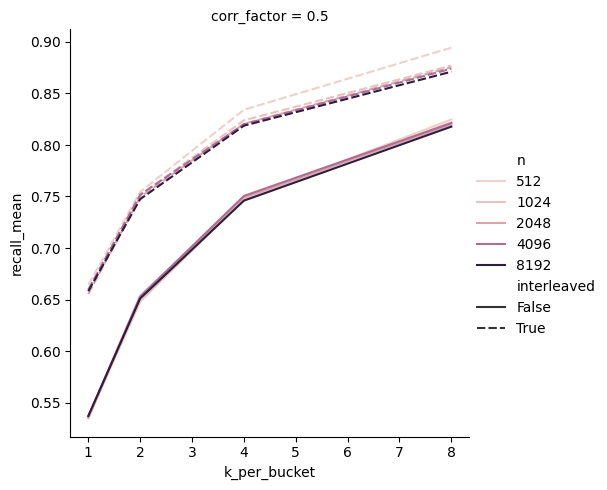

In [7]:
g = sns.relplot(
    data=df,
    x="k_per_bucket",
    y="recall_mean",
    col="corr_factor",
    hue="n",
    style="interleaved",
    kind="line",
)

In [8]:
# Run experiments
n = 2048

n_repetitions = 100
corr_factor = 0.5
k_factor = 8
k_mult = 1

torch.manual_seed(100)

results = []
for corr_factor in [0., 0.2, 0.5, 0.9, 0.999]:
    data = generate_data(n_repetitions, n, corr_factor)
    data_shuffle = data[..., torch.randperm(n)]
    d = {False: data, True: data_shuffle}
    for shuffle in [False, True]:
        for interleaved in [False, True]:
            for k_per_bucket in [1, 2, 4, 8, 16, 32]:
                k = n // k_factor
                recall_mean, recall_std = experiment(
                    d[shuffle], k, k_per_bucket, interleaved, k_mult
                )
                results.append(
                    dict(
                        n=n,
                        n_repetitions=n_repetitions,
                        corr_factor=corr_factor,
                        shuffle=shuffle,
                        k=k,
                        k_per_bucket=k_per_bucket,
                        interleaved=interleaved,
                        k_mul=k_mult,
                        recall_mean=recall_mean,
                        recall_std=recall_std,
                    )
                )

In [9]:
df = pd.DataFrame.from_records(results)
df

,n,n_repetitions,corr_factor,shuffle,k,k_per_bucket,interleaved,k_mul,recall_mean,recall_std
0,2048,100,0.000,False,256,1,False,1,0.657500,0.017193
1,2048,100,0.000,False,256,2,False,1,0.750078,0.017131
2,2048,100,0.000,False,256,4,False,1,0.820977,0.016841
3,2048,100,0.000,False,256,8,False,1,0.871875,0.015625
4,2048,100,0.000,False,256,16,False,1,0.910898,0.016938
...,...,...,...,...,...,...,...,...,...,...
115,2048,100,0.999,True,256,2,True,1,0.746914,0.017357
116,2048,100,0.999,True,256,4,True,1,0.819727,0.016511
117,2048,100,0.999,True,256,8,True,1,0.873828,0.017126
118,2048,100,0.999,True,256,16,True,1,0.909609,0.016005


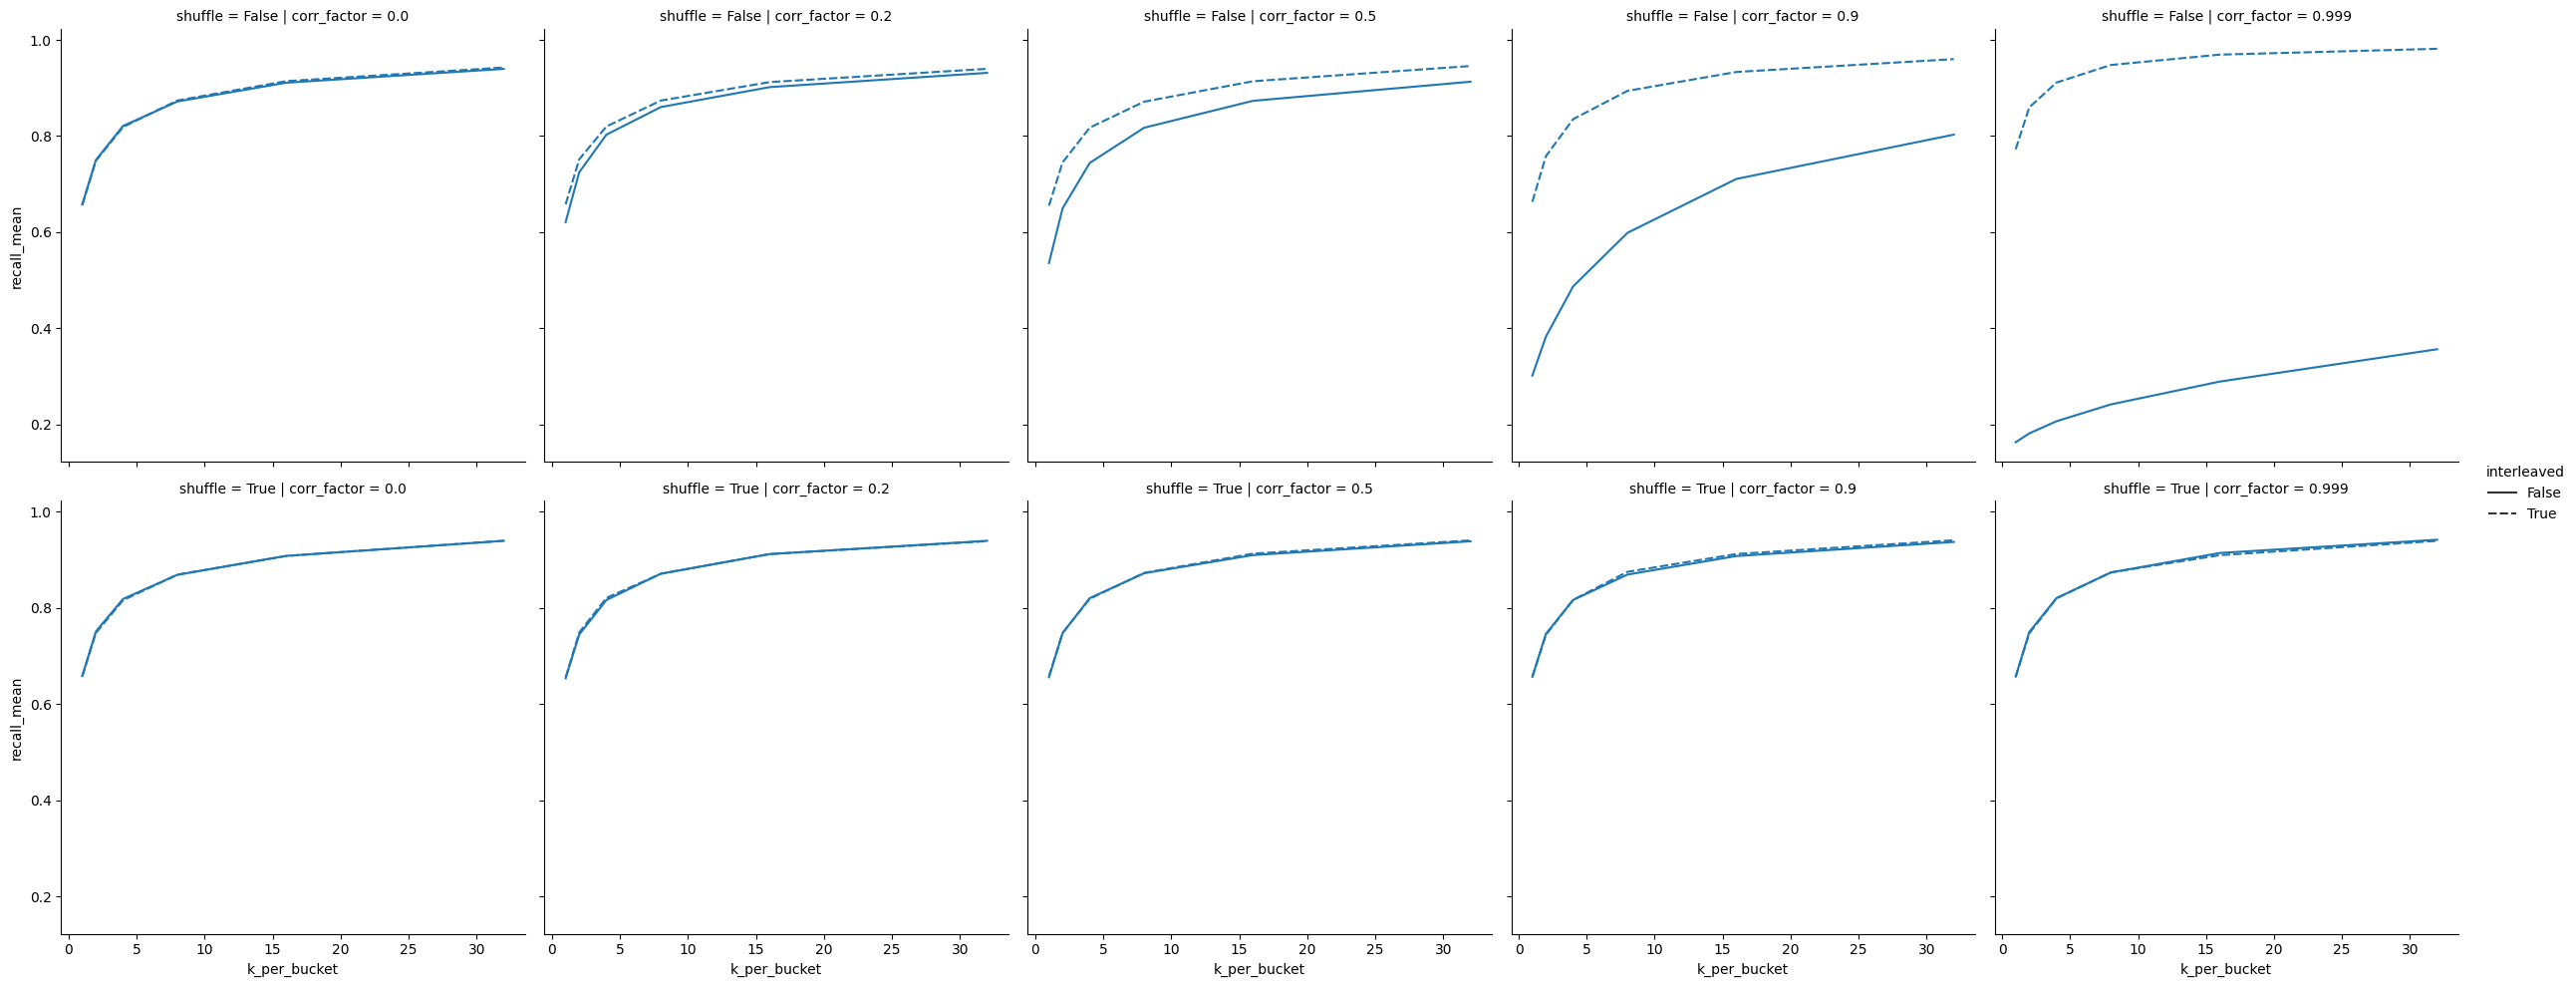

In [10]:
g = sns.relplot(
    data=df,
    x="k_per_bucket",
    y="recall_mean",
    col="corr_factor",
    row="shuffle",
    style="interleaved",
    kind="line",
)